In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,datetime,timedelta
from scipy.spatial.distance import cdist
from sklearn import cluster
%matplotlib inline

# Data preperation

In [10]:
#convert to datetime format and ad new "date" and "hour"-column in datetime format

df["datetime"] = pd.to_datetime(df["Datum"],dayfirst = True) + df["Hour_of_Day"].astype("timedelta64[h]")
df.datetime.dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")

#df["date"]= df['datetime'].apply(lambda x: x.date)
df["day_of_year"] = df["datetime"].apply(lambda x: x.timetuple().tm_yday)
df["hour"]= df['datetime'].apply(lambda x: x.hour)
df.head()


,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear,day_of_year,hour
0,2009-05-01 01:00:00,84544,149,107953001,1/5/2009,2881,0,1,1,0,Ulm,295.0,2009,121,1
1,2009-05-02 01:00:00,84545,149,107953001,2/5/2009,2905,0,2,1,0,Ulm,363.0,2009,122,1
2,2009-05-03 01:00:00,84546,149,107953001,3/5/2009,2929,0,2,1,0,Ulm,316.0,2009,123,1
3,2009-05-04 01:00:00,84547,149,107953001,4/5/2009,2953,0,1,1,0,Ulm,331.0,2009,124,1
4,2009-05-05 01:00:00,84548,149,107953001,5/5/2009,2977,0,1,1,0,Ulm,39.0,2009,125,1


In [11]:
#normalisation:
df['max_energy'] = df.groupby(['Fall_ge1'])['Electricity_Demand'].transform(max)
df['norm_energy'] = df['Electricity_Demand'] / df['max_energy']

In [12]:
#Meteorological seasons:
#winter
sdate_wi = date(2009, 12, 1)   # start date
edate_wi = date(2010, 2, 28)   # end date
#spring
sdate_sp = date(2010, 3, 1)   # start date
edate_sp = date(2010, 5, 31)   # end date
#summer
sdate_su = date(2010, 6, 1)   # start date
edate_su = date(2010, 8, 31)   # end date
#Fall
sdate_fa = date(2009, 9, 1)   # start date
edate_fa = date(2009, 11, 30)   # end date

In [13]:
#filter df by season:
df_fa = df[(df["datetime"] > str(sdate_fa)) & (df["datetime"] <= str(edate_fa))]
df_wi = df[(df["datetime"] > str(sdate_wi)) & (df["datetime"] <= str(edate_wi))]
df_sp = df[(df["datetime"] > str(sdate_sp)) & (df["datetime"] <= str(edate_sp))]
df_su = df[(df["datetime"] > str(sdate_su)) & (df["datetime"] <= str(edate_su))]

In [14]:
#split dataframes into weekday and weekend days
df_fa_week=df_fa[df_fa["Weekday"]==1]
df_fa_wknd=df_fa[df_fa["Weekday"]==2]
df_wi_week=df_wi[df_wi["Weekday"]==1]
df_wi_wknd=df_wi[df_wi["Weekday"]==2]
df_sp_week=df_sp[df_sp["Weekday"]==1]
df_sp_wknd=df_sp[df_sp["Weekday"]==2]
df_su_week=df_su[df_su["Weekday"]==1]
df_su_wknd=df_su[df_su["Weekday"]==2]

In [15]:
df_sp.shape

(134856, 17)

In [16]:
df_su.shape

(132552, 17)

In [17]:
df_wi.shape

(129240, 17)

In [18]:
df_fa.shape

(131928, 17)

In [19]:
df.set_index("datetime", inplace = True)

# Functions for clustering

In [20]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

# Fall

### Fall weekday 

In [21]:
red_df=df_fa_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df

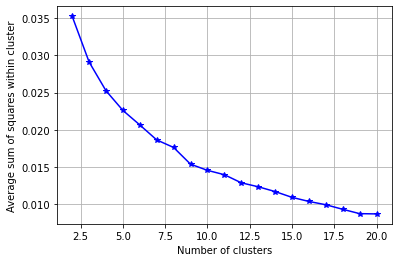

In [22]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [23]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [24]:
cls_list = algorithm.predict(kmeans_df)

kmeans_df['cluster'] = cls_list

In [25]:
fall_week = clustering.cluster_centers_
#clustering.cluster_centers_.mean(axis=1).sort()
clustering.cluster_centers_

array([[0.08034445, 0.04785765, 0.03973984, 0.03643136, 0.03627599,
        0.03595955, 0.04494867, 0.05807486, 0.07524608, 0.08106956,
        0.08413723, 0.08402525, 0.08872195, 0.10339865, 0.09210542,
        0.08304382, 0.08971917, 0.10204499, 0.13040102, 0.13948191,
        0.14898803, 0.14226777, 0.12559463, 0.10260673],
       [0.1088765 , 0.07963103, 0.06374295, 0.05593605, 0.050421  ,
        0.05554787, 0.07018344, 0.10974451, 0.09762398, 0.10929314,
        0.11124422, 0.15734712, 0.21246463, 0.26995279, 0.25686768,
        0.22817464, 0.23000216, 0.24917922, 0.2722635 , 0.26035967,
        0.25822623, 0.279741  , 0.26635249, 0.18195407],
       [0.12254648, 0.09074334, 0.07935658, 0.07473788, 0.05920903,
        0.06220781, 0.07417356, 0.12525533, 0.14230083, 0.1311813 ,
        0.12724202, 0.1215399 , 0.13652451, 0.15077905, 0.13805701,
        0.14077777, 0.1335506 , 0.13229748, 0.15154692, 0.15919443,
        0.18157695, 0.19067706, 0.17705245, 0.15325114],
       [0.085

Text(0.5, 0, 'hour')

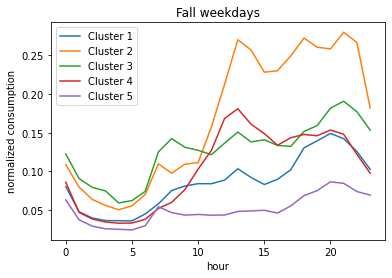

In [26]:
for x in range(0,5,1):
    plt.plot(fall_week[x],label="Cluster " + str(x + 1))
plt.legend()
plt.title("Fall weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Fall weekend 

In [27]:
red_df=df_fa_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df

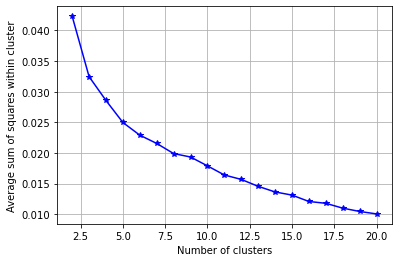

In [28]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [29]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [30]:
cls_list = algorithm.predict(kmeans_df)

kmeans_df['cluster'] = cls_list

In [31]:
fall_week = clustering.cluster_centers_
#clustering.cluster_centers_.mean(axis=1).sort()
clustering.cluster_centers_

array([[0.08278938, 0.06709913, 0.05223056, 0.04530648, 0.04321503,
        0.04244258, 0.04516054, 0.05198949, 0.06503772, 0.09270486,
        0.14552119, 0.17770901, 0.18472718, 0.19946293, 0.17260505,
        0.1469861 , 0.12928279, 0.13267177, 0.15236758, 0.17114413,
        0.1686841 , 0.16190885, 0.13791258, 0.11101277],
       [0.05363355, 0.04241629, 0.0314632 , 0.02938825, 0.02432818,
        0.02392548, 0.0246464 , 0.02663357, 0.03124666, 0.05772776,
        0.06514364, 0.06431995, 0.08472406, 0.06938363, 0.06333575,
        0.05310697, 0.04744498, 0.04439413, 0.0643979 , 0.07078889,
        0.07417313, 0.07520721, 0.06949189, 0.0650461 ],
       [0.22287875, 0.22857005, 0.23011673, 0.22475169, 0.17965635,
        0.14403441, 0.14568984, 0.18622973, 0.1907006 , 0.24345683,
        0.23321008, 0.23882887, 0.29669639, 0.19948525, 0.10150076,
        0.09365862, 0.11333043, 0.10910123, 0.14245149, 0.12294884,
        0.11624254, 0.1758259 , 0.20164818, 0.21392494],
       [0.090

Text(0.5, 0, 'hour')

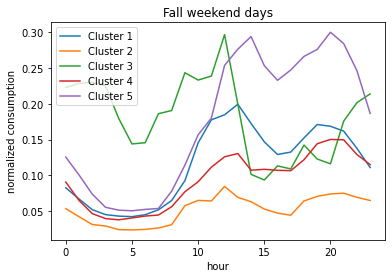

In [32]:
for x in range(0,5,1):
    plt.plot(fall_week[x],label="Cluster " + str(x + 1))
plt.legend()
plt.title("Fall weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Winter

### Winter weekdays

In [33]:
red_df=df_wi_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

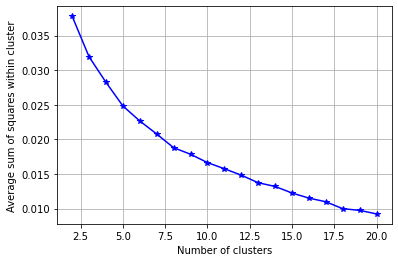

In [34]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [35]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [36]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

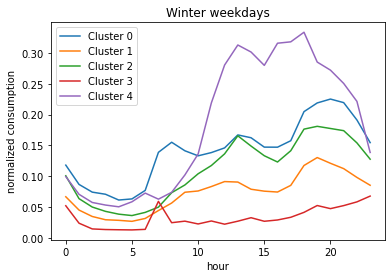

In [37]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Winter weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Winter weekend days

In [38]:
red_df=df_wi_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

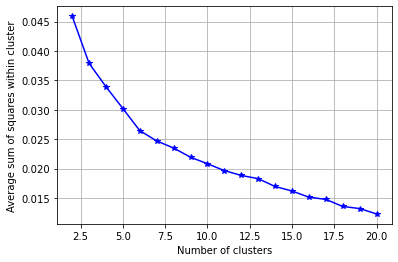

In [39]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [40]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [41]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

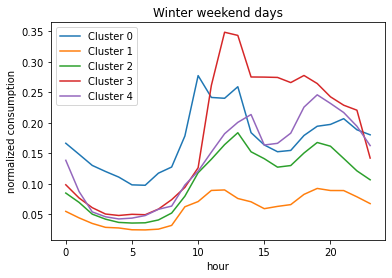

In [42]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Winter weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Spring

### Spring weekdays

In [43]:
red_df=df_sp_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

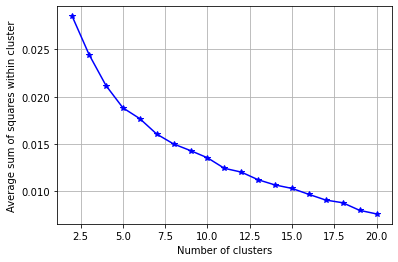

In [44]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [45]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [46]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

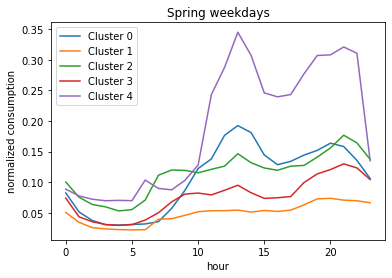

In [47]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Spring weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Spring weekend days

In [48]:
red_df=df_sp_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

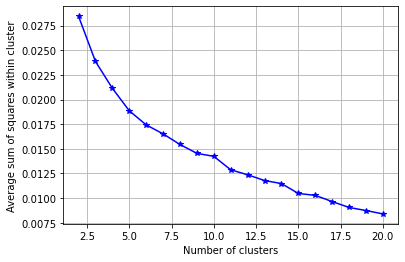

In [49]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [50]:
algorithm = k_algs[5] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[5]

In [51]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

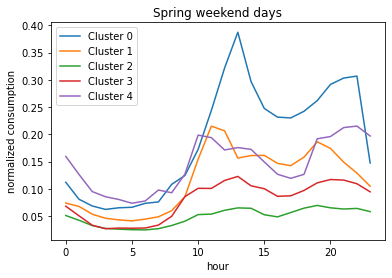

In [52]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Spring weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Summer

### Summer weekdays

In [53]:
red_df=df_su_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

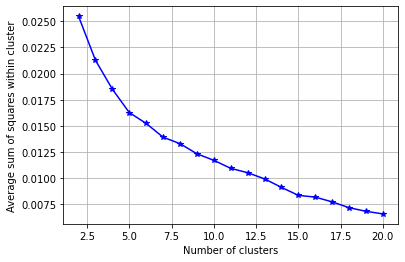

In [54]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [55]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [56]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

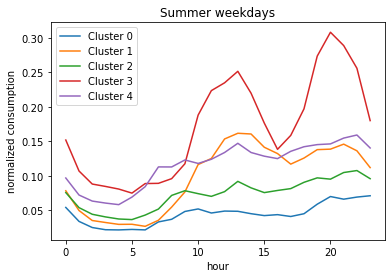

In [57]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Summer weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Summer weekend days

In [58]:
red_df=df_su_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

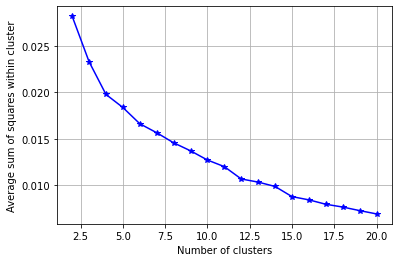

In [59]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [60]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [61]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

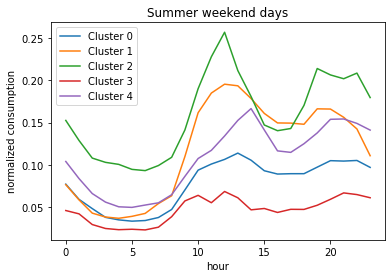

In [62]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Summer weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [63]:
#multiline plot:
def multiline_hourly_plot(dataset, avg = None, ycol = 'Electricity_Demand', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()
    
    return fig

In [64]:
def clusters_visualisation(grp_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = grp_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

In [65]:
kmeans_df["Fall_ge1"]=kmeans_df.index
kmeans_df

hour,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,cluster,Fall_ge1
Fall_ge1,,,,,,,,,,,,,,,,,,,,,
149,0.069912,0.087364,0.065339,0.045414,0.036712,0.033457,0.028476,0.018537,0.011876,0.013357,...,0.082371,0.082744,0.090362,0.061198,0.064907,0.072957,0.051632,0.054082,3,149
151,0.076695,0.080648,0.046780,0.017311,0.016991,0.017345,0.016146,0.017403,0.019059,0.139929,...,0.038713,0.020065,0.023002,0.028429,0.060492,0.068833,0.082693,0.084293,3,151
152,0.022236,0.029543,0.016836,0.028590,0.015883,0.029543,0.024778,0.020648,0.028907,0.020013,...,0.019377,0.031766,0.016201,0.028272,0.049555,0.103875,0.091804,0.074651,3,152
153,0.077582,0.051361,0.037169,0.031453,0.028060,0.028383,0.027290,0.027066,0.028160,0.055275,...,0.069976,0.059898,0.049024,0.077482,0.116267,0.127836,0.129315,0.119113,0,153
155,0.127145,0.106671,0.080786,0.079007,0.080677,0.076411,0.076984,0.095642,0.103612,0.203763,...,0.140099,0.137552,0.140709,0.154370,0.163535,0.193514,0.189078,0.178415,2,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,0.042067,0.067862,0.062654,0.039170,0.036196,0.033053,0.034363,0.033130,0.037814,0.060343,...,0.063317,0.093365,0.075521,0.079096,0.100376,0.092810,0.077925,0.045935,0,1104
1105,0.070303,0.039918,0.029180,0.027684,0.028360,0.028214,0.028969,0.030504,0.036277,0.128585,...,0.151185,0.152363,0.119158,0.165616,0.162968,0.148153,0.147319,0.128598,1,1105
1107,0.075534,0.069683,0.037457,0.032137,0.026404,0.025163,0.025311,0.027838,0.033645,0.043382,...,0.034930,0.062398,0.091152,0.064511,0.072402,0.112311,0.098023,0.095289,3,1107


# Multilineplot example

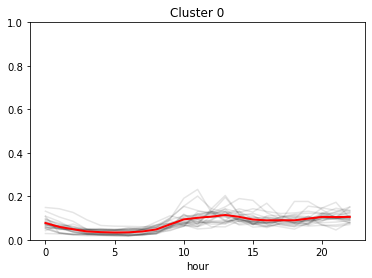

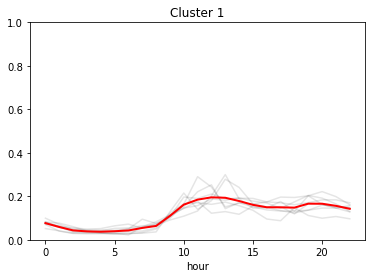

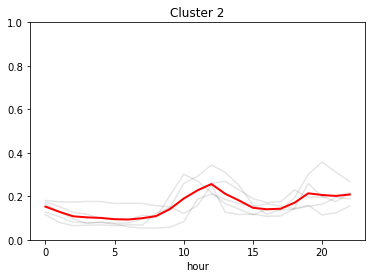

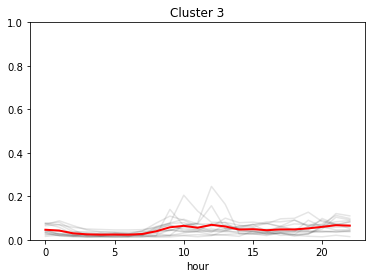

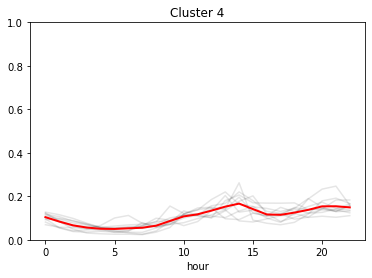

In [66]:
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

## Closer look at one cluster

In [67]:
# cl4_df = kmeans_df[kmeans_df["cluster"]==4]

In [68]:
# cl4_lst = list(cl4_df["Fall_ge1"].unique())
# cl4_lst

In [69]:
# df[df["Fall_ge1"].isin(cl4_lst)].loc["2010-05-02"].groupby("Fall_ge1").Electricity_Demand.plot()

In [70]:
# cl6_df = df[df["Fall_ge1"].isin(cl6_lst)]
# cl6_df["Daten_Herkunft"].unique()